<a href="https://colab.research.google.com/github/SamSham07/data_storage/blob/main/Concrete_Prediction_and_Inverse_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://github.com/acceleratedmaterials/Astar_AMDworkshop_demo/blob/master/property_prediction/demo.ipynb

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(0)
pd.options.display.max_rows = 20

0. Importing the dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/SamSham07/data_storage/main/Concrete_Data.csv')
df

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

X, y = df[df.columns[:-1]], df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

In [ ]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_test, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_test, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_test, y_test)}
    return scores

**1. Linear Regression Baseline**

We first consider a linear regression baseline, where we fit a linear model

In [ ]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_hat_train = regressor.predict(X_train)  # Training set predictions
y_hat_test = regressor.predict(X_test)  # Test set predictions

In [ ]:
# Evaluate the RandomizedSearch model
show_scores(regressor)

{'Training MAE': 8.329066637061821,
 'Training RMSLE': 0.3290273012634245,
 'Training R^2': 0.6091237370441138,
 'Valid MAE': 7.864641991336007,
 'Valid RMSLE': 0.35017665379160606,
 'Valid R^2': 0.6369606518338298}

**2. Gradient Boosting Regression**

Let us now use a more robust regressor for non-linear regression. Again, we use canned implementations from sklearn.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

y_hat_train = regressor.predict(X_train)
y_hat_test = regressor.predict(X_test)

**Feature importance**

Decision tree based ensemble models can also tell us how sensitive (in a very loose sense) the output is to each input parameter.

In [ ]:
# Find feature importance of our best model
regressor.feature_importances_

array([0.29240455, 0.08147877, 0.00890462, 0.0958448 , 0.10977279,
       0.01398109, 0.03877004, 0.35884334])

In [ ]:
import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

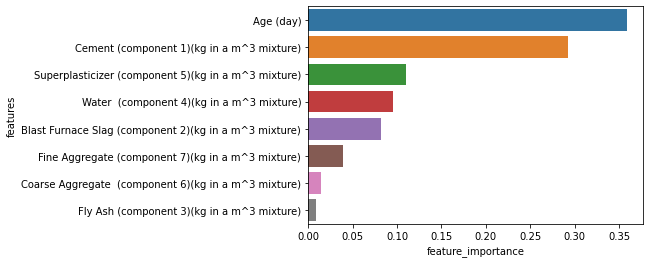

In [ ]:
plot_features(X_train.columns, regressor.feature_importances_)

**2.1 Overfitting**

Here, let us demonstrate overfitting for the gradient boosting regressor. This can be done by drastically increasing the model complexity. One simple way to increase the model complexity is by increasing the max_depth parameter in GradientBoostingRegressor()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(max_depth=10)
regressor.fit(X_train, y_train)

y_hat_train = regressor.predict(X_train)
y_hat_test = regressor.predict(X_test)

In [ ]:
# Evaluate the RandomizedSearch model
show_scores(regressor)

{'Training MAE': 0.11646058984234574,
 'Training RMSLE': 0.029279446772101113,
 'Training R^2': 0.9956195695293864,
 'Valid MAE': 3.874107821651361,
 'Valid RMSLE': 0.18684214325084664,
 'Valid R^2': 0.8630217370083012}

**2.2 Hyper-parameter Tuning**

Observe that GradientBoostingRegressor() performed much better than LinearRegression(). Can we improve it further?

Let us take a quick look at the documentation of GradientBoostingRegressor()

In [ ]:
print(GradientBoostingRegressor.__doc__)

Gradient Boosting for regression.

    GB builds an additive model in a forward stage-wise fashion;
    it allows for the optimization of arbitrary differentiable loss functions.
    In each stage a regression tree is fit on the negative gradient of the
    given loss function.

    Read more in the :ref:`User Guide <gradient_boosting>`.

    Parameters
    ----------
    loss : {'squared_error', 'absolute_error', 'huber', 'quantile'},             default='squared_error'
        Loss function to be optimized. 'squared_error' refers to the squared
        error for regression. 'absolute_error' refers to the absolute error of
        regression and is a robust loss function. 'huber' is a
        combination of the two. 'quantile' allows quantile regression (use
        `alpha` to specify the quantile).

        .. deprecated:: 1.0
            The loss 'ls' was deprecated in v1.0 and will be removed in
            version 1.2. Use `loss='squared_error'` which is equivalent.

        .. de

**Tuning via Random Search CV**

In [ ]:
from scipy import stats 

param_distributions = {
    'n_estimators': stats.randint(low=10, high=1000),
    'max_depth': stats.randint(low=2, high=6),
    'min_samples_split': stats.randint(low=2, high=5),
    'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]
}

**Fit a CV-tuned regressor**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

regressor_cv = RandomizedSearchCV(
    regressor, param_distributions=param_distributions,
    n_iter=50, verbose=1)
regressor_cv.fit(X_train, y_train)

print('Best params: \n', regressor_cv.best_params_)

y_hat_train = regressor_cv.predict(X_train)
y_hat_test = regressor_cv.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: 
 {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 430}


In [ ]:
# Evaluate the RandomizedSearch model
show_scores(regressor_cv)

{'Training MAE': 0.421492505506084,
 'Training RMSLE': 0.03405688909536569,
 'Training R^2': 0.994829552915575,
 'Valid MAE': 2.7736197185778027,
 'Valid RMSLE': 0.1388268039817909,
 'Valid R^2': 0.9337024232726218}

In [ ]:
regressor_cv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=GradientBoostingRegressor(max_depth=10), n_iter=50,
                   param_distributions={'learning_rate': [1, 0.5, 0.25, 0.1,
                                                          0.05, 0.01],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff87cf7f510>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff87cf7f790>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff87cf7f590>},
                   verbose=1)

**Plot predictions and feature importances**

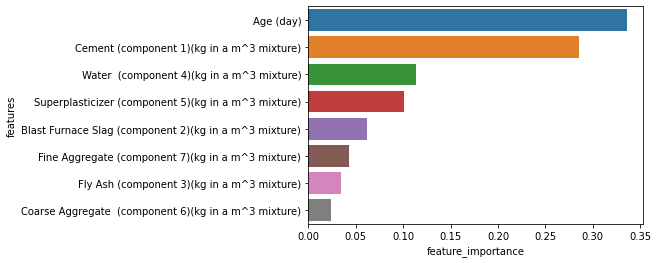

In [ ]:
# Find feature importance of our best model
regressor.feature_importances_

import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")
    

plot_features(X_train.columns, regressor.feature_importances_)

**3. Inverse Design**

After fitting our model, we perform inverse design. In this demo, we do this using the pyswarm module, which is an implementation of the particle swarm optimization method.

**Refit using tuned hyper-parameters**

In [ ]:
best_params = regressor_cv.best_params_
regressor = GradientBoostingRegressor()
regressor.set_params(**best_params)
regressor.fit(X, y)

GradientBoostingRegressor(max_depth=4, min_samples_split=4, n_estimators=393)

**Bounds, objectives and constraints**

Next, we define some bounds, objectives and constraints to be used for inverse design.


1. Upper bounds for all compositions is  the 75th percentile of the training data.


2. Lower bounds for all compositions is  the 25th percentile of the training data


3. Objective: minimize Blast Furnace Slag, Fly Ash, Superplasticizer compositions


4. Constraints:
   
   Compressive strength >= 70 MPa

   Water <= 150 kg / m^3

   Age <= 30 days

In [ ]:
upper_bounds = np.percentile(X, 75, axis=0) * 1.5
lower_bounds = np.percentile(X, 25, axis=0) * 0.5

def objective(X):
    """
    We want to minimize
        Blast Furnace Slag, Fly Ash, Superplasticizer
    """
    return X[1]**2 + X[2]**2 + X[4]**2

def constraints(X):
    """
    We want to following constraints:
        1. Compressive strength >= 70 MPa
        2. Water <= 150 kg / m^3
        3. Age <= 30 days
    """
    predicted_strength = regressor.predict(X.reshape(1, -1))
    cons_str_lower = predicted_strength - 70
    cons_water_upper = 150 - X[3]
    cons_age_upper = 30 - X[-1]
    return [cons_str_lower, cons_water_upper, cons_age_upper]

**Design via particle swarm optimization**

In [ ]:
!pip install pyswarm

In [ ]:
from pyswarm import pso

X_opts = []
n_runs = 5
for n in range(n_runs):
    X_opt, _ = pso(
        objective, lower_bounds, upper_bounds, f_ieqcons=constraints,
        swarmsize=100, maxiter=200)
    X_opts.append(X_opt)
X_opts = np.asarray(X_opts)
y_hat_opts = regressor.predict(X_opts).reshape(-1, 1)
data_opt = np.concatenate([X_opts, y_hat_opts], axis=1)
df_predict = pd.DataFrame(columns=df.columns, data=data_opt)

**Compare with unseen data**

In fact, our dataset used in this demo is not the full dataset. We took out one sample that satisfies the constraints above and minimizes the objective. Let us now check how close our inverse-design results are to this unseen data point (colored red).

In [ ]:
df_unseen = pd.read_csv('https://raw.githubusercontent.com/SamSham07/data_storage/main/Concrete_Data_unseen.csv')
df_combined = pd.concat([df_predict, df_unseen], ignore_index=True)
df_combined.style.applymap(lambda x: 'color: red', subset=5)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,450.969542,0.000000,0.000000,87.837163,0.000000,1221.419213,820.496279,22.743301,81.516061
1,457.060101,0.000000,0.000000,114.154359,0.000000,1153.686949,862.235506,27.421390,79.047033
2,399.907106,0.000000,0.000000,134.216080,0.000000,1230.251020,1007.306723,24.445038,73.084757
3,408.362487,0.000000,0.000000,140.501972,0.000000,1155.153286,638.825675,25.961168,76.778176
4,525.000000,0.000000,0.000008,129.906361,0.000000,1294.213522,645.195825,21.860747,81.078075
5,485.000000,0.000000,0.000000,146.000000,0.000000,1120.000000,800.000000,28.000000,71.990000
